In [40]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [41]:
torch.cuda.empty_cache()


In [42]:
!nvidia-smi

Sat Nov  2 20:44:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    Off |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8              6W /  320W |   12411MiB /  16376MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Loading the dataset**

In [43]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, phase, transform):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

        self.image_paths = []
        self.clean_paths = []
        self.mask_paths = []
        self.labels = []  # List to store labels (class names)

        # Iterate through all classes in the root directory
        self.classes = os.listdir(root_dir)
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            phase_dir = os.path.join(class_path, self.phase)

            # Check if phase_dir exists
            if os.path.exists(phase_dir):
                print(f"Processing class: {class_name} in {phase_dir}")  # Debugging statement
                
                for folder_type in ['Defect_mask', 'Degraded_image', 'GT_clean_image']:
                    self._load_images_for_folder_type(phase_dir, folder_type, class_name)

    def _load_images_for_folder_type(self, phase_dir, folder_type, class_name):
        folder_path = os.path.join(phase_dir, folder_type)
        print(f"Looking for folder: {folder_path}")  # Debugging statement

        # Ensure the folder exists before loading
        if os.path.exists(folder_path):
            for defect_type in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, defect_type)
                print(f"Checking subfolder: {subfolder_path}")  # Debugging statement

                # Ensure subfolder exists
                if os.path.isdir(subfolder_path):
                    for image_name in os.listdir(subfolder_path):
                        image_path = os.path.join(subfolder_path, image_name)

                        # Append paths and labels based on the folder type
                        if folder_type == 'Degraded_image':
                            self.image_paths.append(image_path)
                            self.labels.append(class_name)  # Store the class label
                        elif folder_type == 'GT_clean_image':
                            self.clean_paths.append(image_path)
                        elif folder_type == 'Defect_mask':
                            self.mask_paths.append(image_path)

                    # Print how many images were loaded from each subfolder
                    print(f"Loaded {len(os.listdir(subfolder_path))} images from {subfolder_path}")
                    print(f"Loaded {len(self.image_paths)} degraded images, {len(self.clean_paths)} clean images, {len(self.mask_paths)} masks from {folder_type}.")
        else:
            print(f"Folder does not exist: {folder_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load images using PIL
        degraded_image = Image.open(self.image_paths[idx]).convert('RGB')
        clean_image = Image.open(self.clean_paths[idx]).convert('RGB')
        mask_image = Image.open(self.mask_paths[idx])  # Grayscale mask
        label = self.labels[idx]  # Get the label (class name)

        # Apply any transformations if specified
        if self.transform:
            degraded_image = self.transform(degraded_image)
            clean_image = self.transform(clean_image)
            mask_image = self.transform(mask_image)

        return degraded_image, clean_image, mask_image, label  # Include label in the return tuple


In [44]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [45]:
dataset_path = '/home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val'

In [46]:
# Create dataset for training data
train_dataset = MVTecDataset(root_dir=dataset_path, phase='Train', transform=transform)

Processing class: grid in /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Train
Looking for folder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Train/Defect_mask
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Train/Defect_mask/metal_contamination
Loaded 8 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Train/Defect_mask/metal_contamination
Loaded 0 degraded images, 0 clean images, 8 masks from Defect_mask.
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Train/Defect_mask/bent
Loaded 9 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Train/Defect_mask/bent
Loaded 0 degraded images, 0 clean images, 17 masks from Defect_mask.
Checking subfolder: /home

In [47]:
print(f"Total number of degraded images: {len(train_dataset.image_paths)}")
print(f"Total number of clean images: {len(train_dataset.clean_paths)}")
print(f"Total number of defect masks: {len(train_dataset.mask_paths)}")

Total number of degraded images: 932
Total number of clean images: 932
Total number of defect masks: 932


In [48]:
# Create dataset for validation data
val_dataset = MVTecDataset(root_dir=dataset_path, phase='Val', transform=transform)

Processing class: grid in /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val
Looking for folder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/metal_contamination
Loaded 1 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/metal_contamination
Loaded 0 degraded images, 0 clean images, 1 masks from Defect_mask.
Checking subfolder: /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/bent
Loaded 1 images from /home/user/Downloads/Deep_learning_for_imaging/Class_project/Denoising_Dataset_train_val/grid/Val/Defect_mask/bent
Loaded 0 degraded images, 0 clean images, 2 masks from Defect_mask.
Checking subfolder: /home/user/Downloa

In [49]:
print(f"Total number of degraded images: {len(val_dataset.image_paths)}")
print(f"Total number of clean images: {len(val_dataset.clean_paths)}")
print(f"Total number of defect masks: {len(val_dataset.mask_paths)}")


Total number of degraded images: 88
Total number of clean images: 88
Total number of defect masks: 88


In [50]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Displaying sample images

In [51]:

degraded_img, clean_img, mask_img, label = train_dataset[0]  # Access the first sample


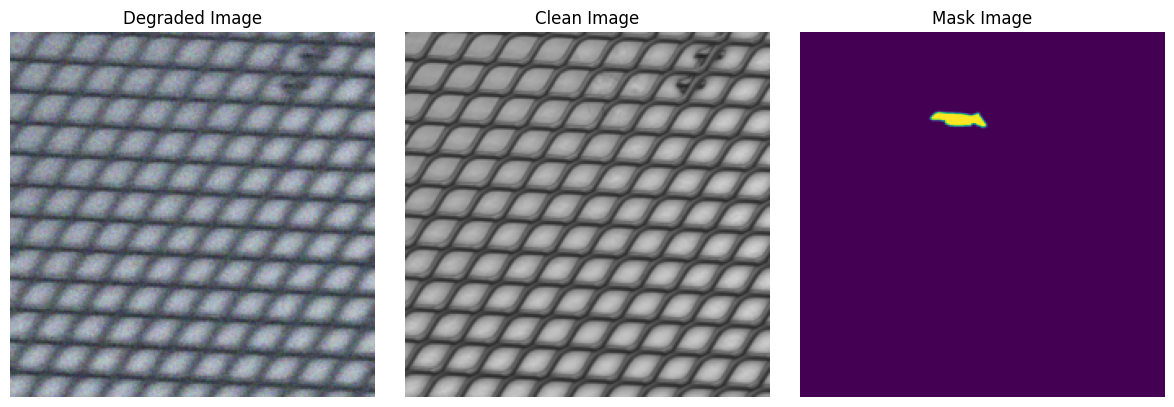

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose images if needed (assuming they are (3, 224, 224))
degraded_img = np.transpose(degraded_img, (1, 2, 0))
clean_img = np.transpose(clean_img, (1, 2, 0))
mask_img = np.transpose(mask_img, (1, 2, 0))

# Set up a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot each image in a separate subplot
axs[0].imshow(degraded_img)
axs[0].axis('off')
axs[0].set_title('Degraded Image')

axs[1].imshow(clean_img)
axs[1].axis('off')
axs[1].set_title('Clean Image')

axs[2].imshow(mask_img)
axs[2].axis('off')
axs[2].set_title('Mask Image')

plt.tight_layout()  # Optional: adjusts spacing between plots for a cleaner look
plt.show()



In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [54]:
import skimage.metrics
import numpy as np

def calculate_metrics(original, restored, win_size=None):
    # Ensure images are in float32 format
    original = original.astype(np.float32)
    restored = restored.astype(np.float32)

    # Ensure the images are in the expected range
    original = np.clip(original, 0, 1)
    restored = np.clip(restored, 0, 1)

    # Calculate PSNR
    psnr_value = skimage.metrics.peak_signal_noise_ratio(original, restored, data_range=1.0)

    # Debugging: Print shapes and dtypes
    print(f"Original shape: {original.shape}, Restored shape: {restored.shape}")
    print(f"Original dtype: {original.dtype}, Restored dtype: {restored.dtype}")

    # Dynamically adjust win_size for SSIM
    min_dim = min(original.shape[:2])  # Get the smallest dimension
    win_size = min(11, min_dim) if min_dim % 2 == 1 else min(11, min_dim - 1)

    # Calculate SSIM with appropriate parameters
    ssim_value = skimage.metrics.structural_similarity(
        original,
        restored,
        data_range=1.0,
        win_size=win_size,
        channel_axis=-1  # Set to -1 if channels are in the last dimension
    )
    
    return psnr_value, ssim_value


**Using Autoencoder**

In [55]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (N, 3, H, W) -> (N, 64, H, W)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (N, 64, H, W) -> (N, 128, H/2, W/2)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding =1),  # (N, 128, H, W) -> (N, 64, H, W)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),  # (N, 64, H, W) -> (N, 3, H, W)
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

# Assuming `train_dataset` is already defined
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize the model, loss function, and optimizer
model_AE = Autoencoder().to(device)  # Use GPU if available
criterion = nn.MSELoss()
optimizer = optim.Adam(model_AE.parameters(), lr=1e-3)

num_epochs = 15  # Set the number of epochs
for epoch in range(num_epochs):
    for degraded, clean, mask, label in train_loader:
        degraded, clean = degraded.to(device), clean.to(device)

        # Forward pass
        outputs = model_AE(degraded)
        loss = criterion(outputs, clean)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/15], Loss: 0.0035
Epoch [2/15], Loss: 0.0041
Epoch [3/15], Loss: 0.0026
Epoch [4/15], Loss: 0.0041
Epoch [5/15], Loss: 0.0035
Epoch [6/15], Loss: 0.0035
Epoch [7/15], Loss: 0.0021
Epoch [8/15], Loss: 0.0013
Epoch [9/15], Loss: 0.0032
Epoch [10/15], Loss: 0.0026
Epoch [11/15], Loss: 0.0021
Epoch [12/15], Loss: 0.0021
Epoch [13/15], Loss: 0.0015
Epoch [14/15], Loss: 0.0019
Epoch [15/15], Loss: 0.0021


In [ ]:
#Saving the model
torch.save(model_AE, 'ae_model_full_updated.pth')  #Saving entire model
torch.save(model_AE.state_dict(), 'ae_model_updated_weights.pth') #Saving only weights

In [56]:
#Loading the model
#Loading from the entire model
# Load the entire model
model_AE = torch.load('ae_model_full_updated.pth')
model_AE = model_AE.to(device)  # Move to the appropriate device
#model_AE.eval()  # Set to evaluation mode for inference


/tmp/ipykernel_3124473/223967388.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_AE = torch.load('ae_model_full_updated.pth')


In [57]:
#Loading from only the weights
# Initialize the model (redefine architecture)
model_AE = Autoencoder().to(device)


# Load the state dictionary (weights)
model_AE.load_state_dict(torch.load('ae_model_updated_weights.pth'))

# Set to evaluation mode for inference
#model_AE.eval()



/tmp/ipykernel_3124473/2896856108.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_AE.load_state_dict(torch.load('ae_model_updated_weights.pth'))


<All keys matched successfully>

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.695185052798664, SSIM: 0.7033158540725708


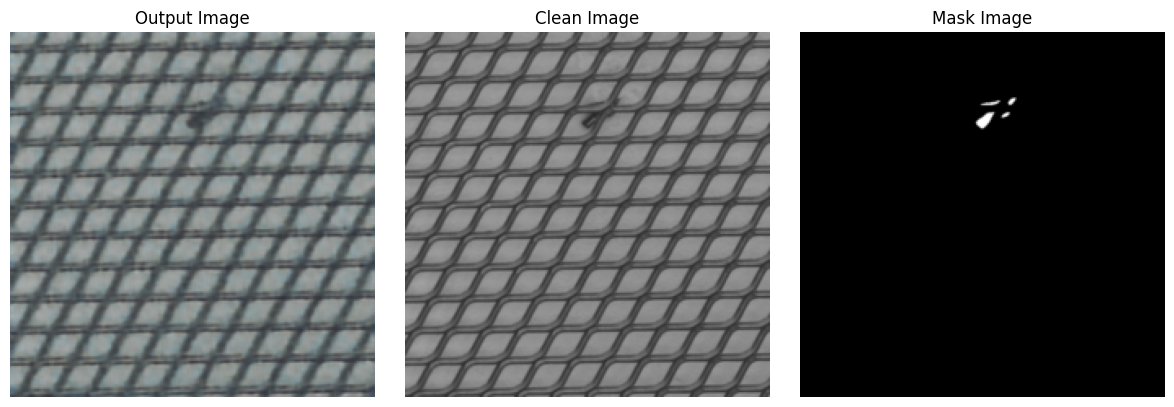

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.545047114460502, SSIM: 0.7156935930252075
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.018378829556994, SSIM: 0.722366988658905
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.62864540061949, SSIM: 0.7962418794631958
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 25.86213308630155, 

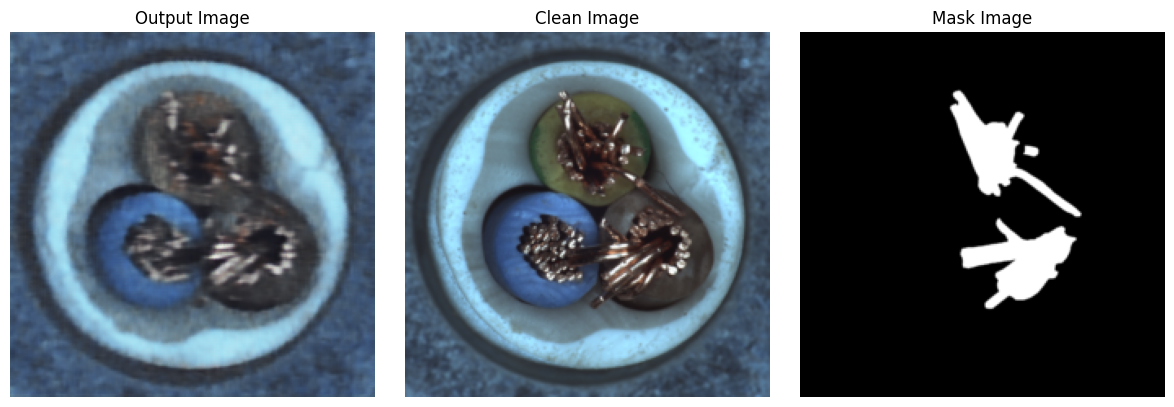

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.32127288272677, SSIM: 0.9109727144241333
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.060235238894286, SSIM: 0.8209396004676819
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.808557433357176, SSIM: 0.8305854797363281
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.6482091350012, 

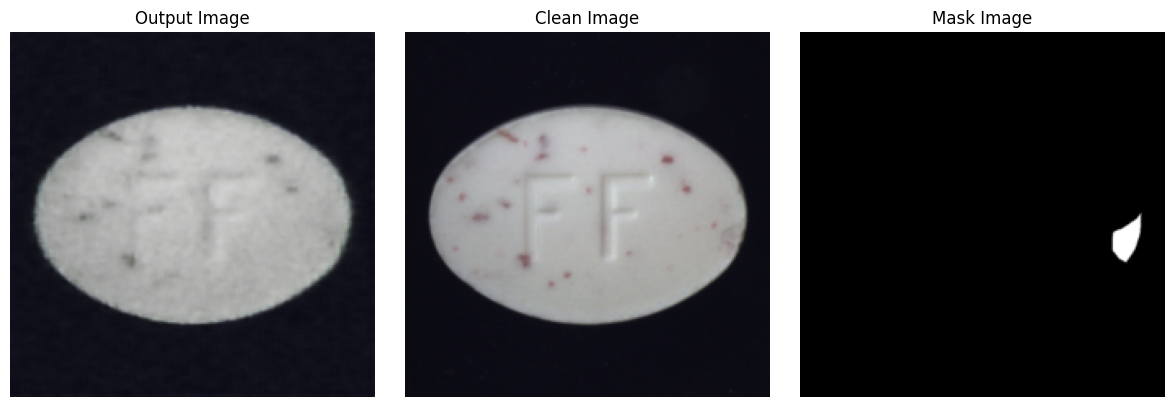

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 32.61158222628925, SSIM: 0.9386000037193298
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.145367689029875, SSIM: 0.9342244863510132
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 32.70610828322634, SSIM: 0.9401487112045288
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 26.642355744000675,

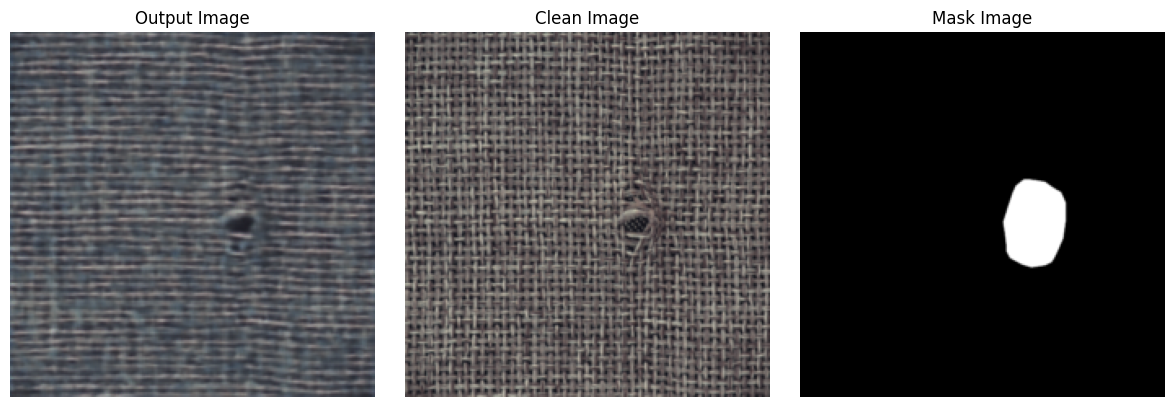

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.998297150000575, SSIM: 0.7357390522956848
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.69582422521193, SSIM: 0.7619617581367493
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.819743333670267, SSIM: 0.7928416132926941
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.325083299290345

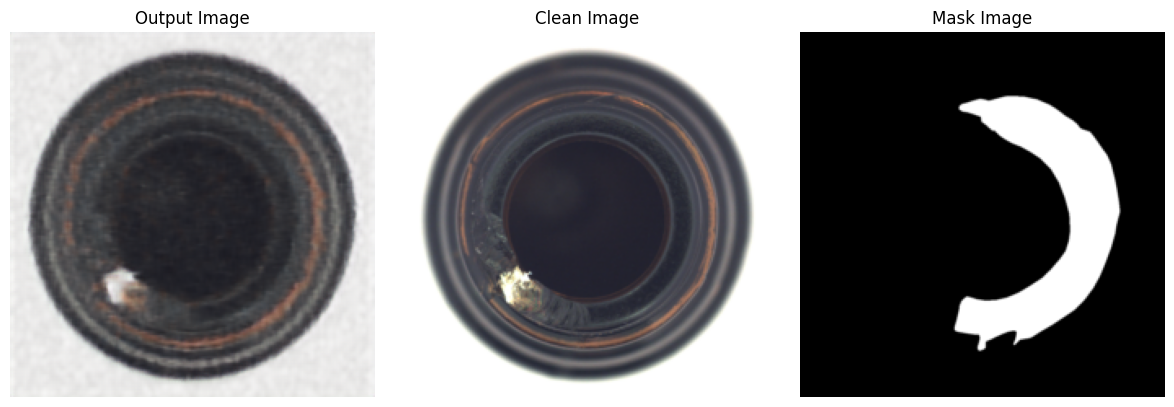

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.90351647723795, SSIM: 0.8864126205444336
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.91473140123545, SSIM: 0.8853666186332703
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.490710808079513, SSIM: 0.8634027242660522
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.827246915385523,

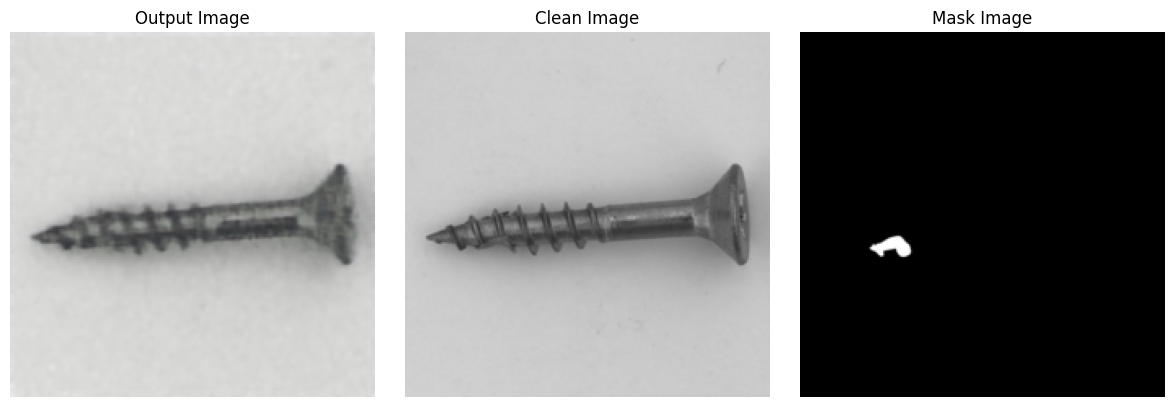

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.91510846580449, SSIM: 0.5780476331710815
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.93561527477429, SSIM: 0.9532898664474487
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 31.524312704523922, SSIM: 0.9493536353111267
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 32.16244807898531, 

In [58]:
import matplotlib.pyplot as plt
# Load test or validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  #Currently given bathc_size = 1

psnr_values = []
ssim_values = []

with torch.no_grad():
    for degraded, clean, mask, label in val_loader:
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays for each image in the batch
        output_images = outputs.cpu().numpy()
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        # Loop through each image in the batch
        for i in range(output_images.shape[0]):
            output_image = output_images[i].squeeze()
            clean_image = clean_images[i].squeeze()
            mask_image = mask_images[i].squeeze()

            # Check image shapes before calculating metrics
            print(f'Clean image shape: {clean_image.shape}')
            print(f'Output image shape: {output_image.shape}')
            print(f'Mask image shape: {mask_image.shape}')


            # Calculate metrics for each image
            psnr, ssim = calculate_metrics(clean_image, output_image)
            print(f'PSNR: {psnr}, SSIM: {ssim}')

            if i == 0: #Instead of showing all images in each batch, I am showing only first image in each batch for not to exceed file size while uploading in github

                # Transpose if necessary for visualization
                output_img = np.transpose(output_image, (1, 2, 0)) if output_image.ndim == 3 else output_image
                clean_img = np.transpose(clean_image, (1, 2, 0)) if clean_image.ndim == 3 else clean_image
                mask_img = np.transpose(mask_image, (1, 2, 0)) if mask_image.ndim == 3 else mask_image

                # Set up a figure with 1 row and 3 columns
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                # Plot each image in a separate subplot
                axs[0].imshow(output_img)
                axs[0].axis('off')
                axs[0].set_title('Output Image')

                axs[1].imshow(clean_img)
                axs[1].axis('off')
                axs[1].set_title('Clean Image')

                axs[2].imshow(mask_img, cmap='gray')
                axs[2].axis('off')
                axs[2].set_title('Mask Image')

                plt.tight_layout()
                plt.show()

            psnr_values.append(psnr)
            ssim_values.append(ssim)

    # Calculate average PSNR and SSIM
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)

# Print average values
print(f"Average PSNR for the entire test set: {average_psnr:.2f}")
print(f"Average SSIM for the entire test set: {average_ssim:.2f}")


Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 51.96775598911501, Defect SSIM: 0.9994745850563049


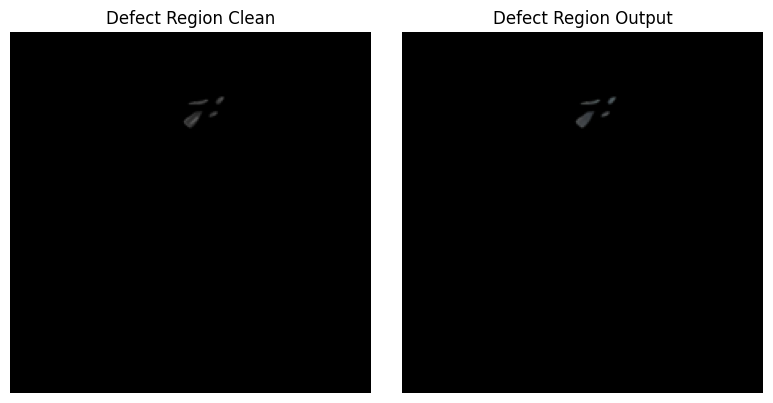

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.799423383348675, Defect SSIM: 0.9941980242729187
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 46.69398204821764, Defect SSIM: 0.9987184405326843
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.21904535755637, Defect SSIM: 0.9964564442634583
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 45.70719193600865, Defect SSIM: 0.9984025955200195
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 48.79443991990183, Defect SSIM: 0.995494544506073
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.7044

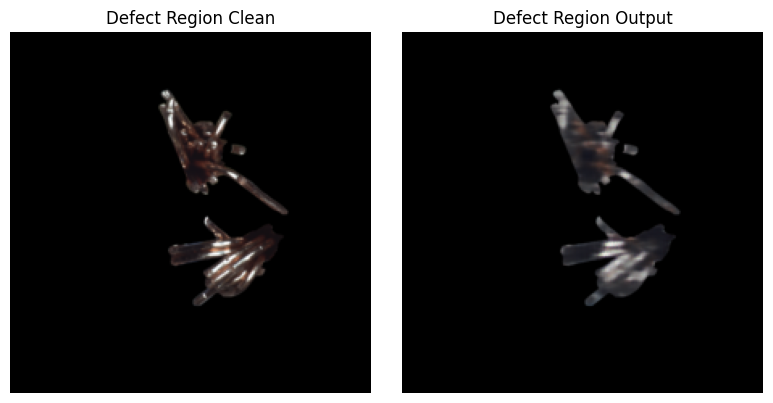

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.35027192185873, Defect SSIM: 0.9966477155685425
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.84327980738527, Defect SSIM: 0.9768346548080444
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.46401963872947, Defect SSIM: 0.9871653914451599
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 47.99609293512687, Defect SSIM: 0.9971380233764648
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.809857346936276, Defect SSIM: 0.994107723236084
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 31.8098

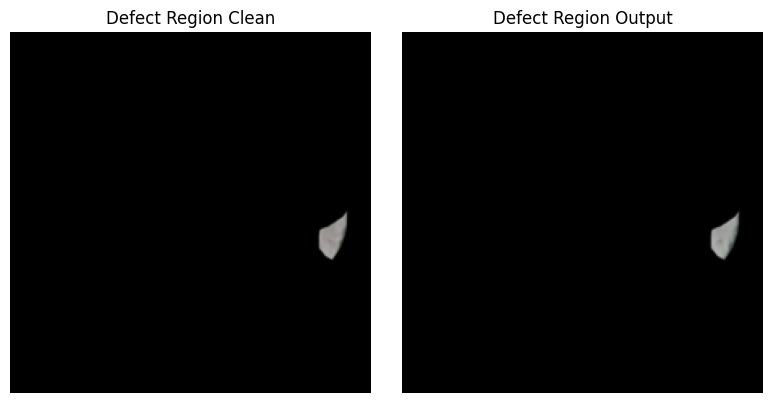

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 49.57637880248963, Defect SSIM: 0.9983311891555786
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.54376223464377, Defect SSIM: 0.9984296560287476
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 46.40648894497011, Defect SSIM: 0.9977537393569946
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 28.93640185641115, Defect SSIM: 0.8421770334243774
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.73091451117968, Defect SSIM: 0.9954290390014648
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 49.1138

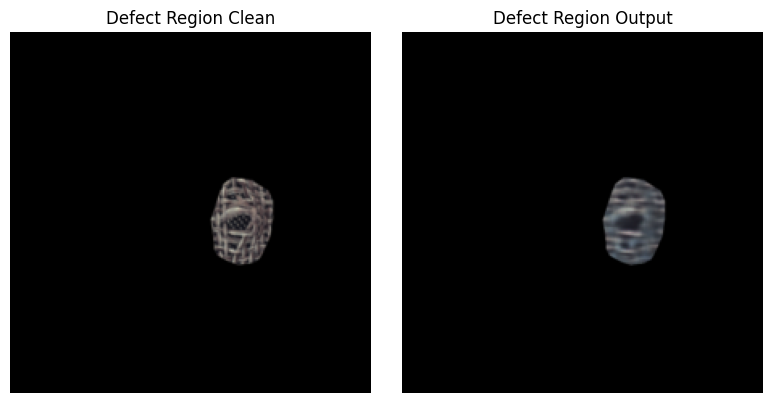

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.8366261031989, Defect SSIM: 0.9968482255935669
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 48.63424906670714, Defect SSIM: 0.9993480443954468
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.08968742069575, Defect SSIM: 0.9972321391105652
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.93467732048148, Defect SSIM: 0.9834361672401428
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 52.12133449369813, Defect SSIM: 0.9999000430107117
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 53.40486

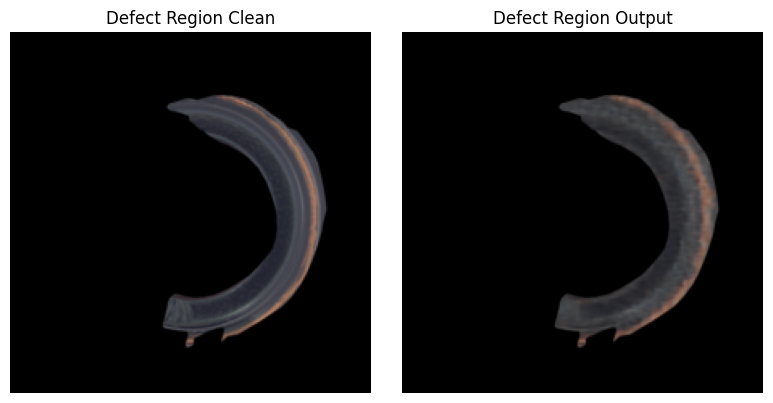

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 36.392798830669065, Defect SSIM: 0.9824081659317017
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.41487482655104, Defect SSIM: 0.9954783320426941
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.358214476066415, Defect SSIM: 0.9990015625953674
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 42.42270477963765, Defect SSIM: 0.9987240433692932
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.91754482529335, Defect SSIM: 0.9950103759765625
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.11

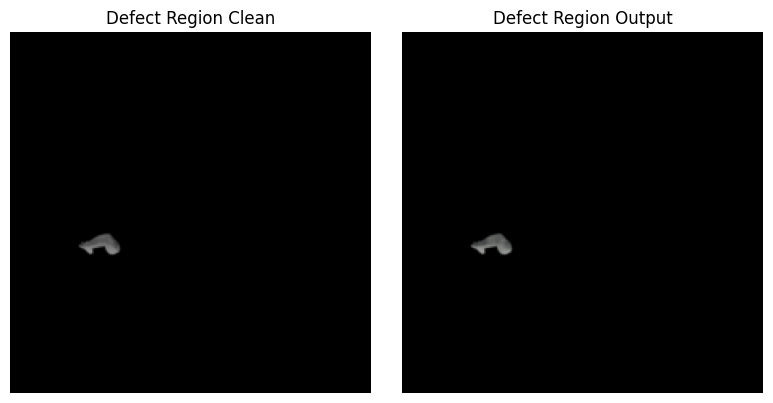

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 53.15663538342426, Defect SSIM: 0.998776912689209
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 51.56581424421161, Defect SSIM: 0.9994747042655945
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 42.656544974347746, Defect SSIM: 0.9969318509101868
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 34.82556477035595, Defect SSIM: 0.9746733903884888
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 39.53303075438299, Defect SSIM: 0.9963034987449646
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 32.9577

In [59]:
import matplotlib.pyplot as plt

psnr_values_defect = []
ssim_values_defect = []

with torch.no_grad():
    for degraded, clean, mask, label in val_loader:
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays while keeping the batch dimension
        output_images = outputs.cpu().numpy()  # Shape: (batch_size, C, H, W)
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        for i in range(output_images.shape[0]):  # Loop over each image in the batch
            output_image = output_images[i]  # Shape: (C, H, W)
            clean_image = clean_images[i]
            mask_image = mask_images[i]

            # Isolate defect regions using the mask
            defect_region_output = output_image * mask_image
            defect_region_clean = clean_image * mask_image

            # Calculate PSNR and SSIM over defect regions only
            psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)
            print(f'Defect PSNR: {psnr_defect}, Defect SSIM: {ssim_defect}')
            

            if i==0: #Instead of showing all images in each batch, I am showing only first image in each batch for not to exceed file size while uploading in github
                # Transpose for displaying with matplotlib
                defect_region_output = np.transpose(defect_region_output, (1, 2, 0))  # (H, W, C)
                defect_region_clean = np.transpose(defect_region_clean, (1, 2, 0))

                # Display defect regions
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(defect_region_clean)
                axs[0].axis('off')
                axs[0].set_title('Defect Region Clean')

                axs[1].imshow(defect_region_output)
                axs[1].axis('off')
                axs[1].set_title('Defect Region Output')

                plt.tight_layout()
                plt.show()

                # Append to lists
                psnr_values_defect.append(psnr_defect)
                ssim_values_defect.append(ssim_defect)

    # Calculate average defect PSNR and SSIM
    average_psnr_defect = np.mean(psnr_values_defect)
    average_ssim_defect = np.mean(ssim_values_defect)

# Print or save the defect-specific average PSNR and SSIM
print(f"Average PSNR for defect regions: {average_psnr_defect:.2f}")
print(f"Average SSIM for defect regions: {average_ssim_defect:.2f}")


Saving output images and average PSNR and average SSIM values in a folder

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Original s

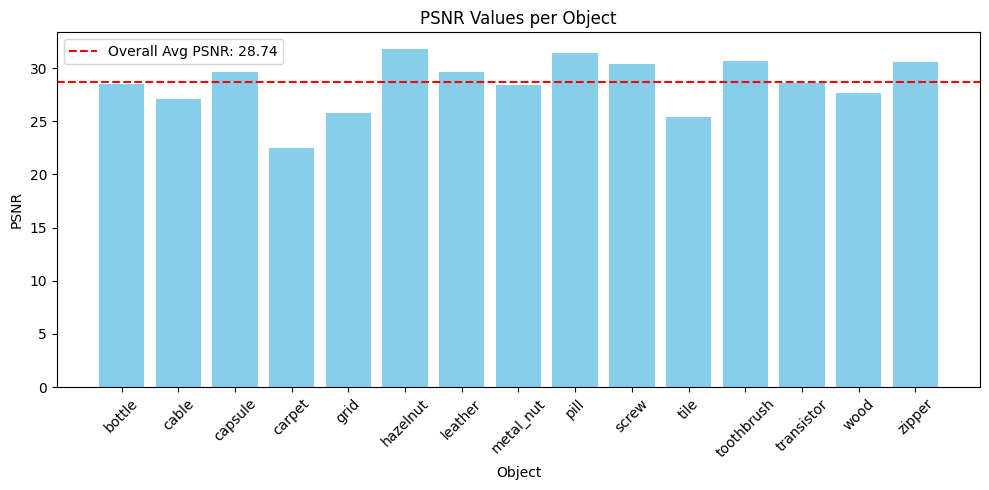

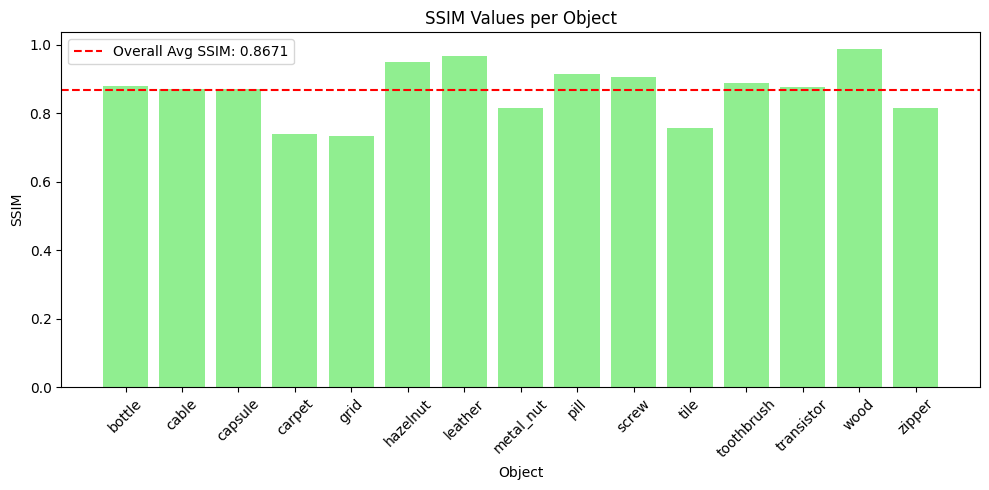

In [60]:
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Set up output folder
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Initialize dictionaries to store PSNR and SSIM values by object type
object_psnr = defaultdict(list)
object_ssim = defaultdict(list)

# Initialize file for saving PSNR and SSIM metrics
metrics_file = os.path.join(output_folder, "metrics.txt")
with open(metrics_file, "w") as f:
    f.write("PSNR and SSIM values for each test image:\n\n")

with torch.no_grad():
    for idx, (degraded, clean, mask, label) in enumerate(val_loader):  # Assume `label` is object name
        degraded = degraded.to(device)
        outputs = model_AE(degraded)

        # Convert tensors to numpy arrays for each image in the batch
        output_images = outputs.cpu().numpy()
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        for i in range(output_images.shape[0]):
            output_image = output_images[i].squeeze()
            clean_image = clean_images[i].squeeze()
            mask_image = mask_images[i].squeeze()
            object_name = label[i]  # Extract object name for each sample in the batch

            # Save each output image
            output_img = np.transpose(output_image, (1, 2, 0)) if output_image.ndim == 3 else output_image
            output_path = os.path.join(output_folder, f"{object_name}_output_image_{idx * val_loader.batch_size + i}.png")
            plt.imsave(output_path, output_img, cmap='gray' if output_img.ndim == 2 else None)

            # Calculate PSNR and SSIM over the entire image
            psnr_value, ssim_value = calculate_metrics(clean_image, output_image)

            # Calculate defect-specific PSNR and SSIM
            defect_region_output = output_image * mask_image
            defect_region_clean = clean_image * mask_image
            smallest_dimension = min(defect_region_clean.shape[-2:])
            win_size = smallest_dimension if smallest_dimension % 2 == 1 else smallest_dimension - 1
            psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)

            # Store metrics by object type
            object_psnr[object_name].append(psnr_value)
            object_ssim[object_name].append(ssim_value)

            # Write individual metrics to file
            with open(metrics_file, "a") as f:
                f.write(f"Object: {object_name}, Image {idx * val_loader.batch_size + i + 1}: PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}\n")
                f.write(f"Defect Region: PSNR = {psnr_defect:.2f}, SSIM = {ssim_defect:.4f}\n\n")

    # Calculate and save overall average PSNR and SSIM
    overall_psnr = np.mean([psnr for psnr_list in object_psnr.values() for psnr in psnr_list])
    overall_ssim = np.mean([ssim for ssim_list in object_ssim.values() for ssim in ssim_list])

    # Write overall averages to the file
    with open(metrics_file, "a") as f:
        f.write("\nAverage PSNR and SSIM for each object type:\n")
        for object_name in sorted(object_psnr.keys()):
            avg_psnr = np.mean(object_psnr[object_name])
            avg_ssim = np.mean(object_ssim[object_name])
            f.write(f"{object_name}: PSNR = {avg_psnr:.2f}, SSIM = {avg_ssim:.4f}\n")
        f.write(f"\nOverall Average PSNR: {overall_psnr:.2f}\n")
        f.write(f"Overall Average SSIM: {overall_ssim:.4f}\n")

# Print overall average values
print(f"Overall Average PSNR: {overall_psnr:.2f}")
print(f"Overall Average SSIM: {overall_ssim:.4f}")

# Plot object-wise and overall average PSNR/SSIM
objects = sorted(object_psnr.keys())
avg_psnr_values = [np.mean(object_psnr[obj]) for obj in objects]
avg_ssim_values = [np.mean(object_ssim[obj]) for obj in objects]

# Plot PSNR
plt.figure(figsize=(10, 5))
plt.bar(objects, avg_psnr_values, color="skyblue")
plt.axhline(overall_psnr, color="red", linestyle="--", label=f"Overall Avg PSNR: {overall_psnr:.2f}")
plt.title("PSNR Values per Object")
plt.xlabel("Object")
plt.ylabel("PSNR")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "psnr_per_object.png"))
plt.show()

# Plot SSIM
plt.figure(figsize=(10, 5))
plt.bar(objects, avg_ssim_values, color="lightgreen")
plt.axhline(overall_ssim, color="red", linestyle="--", label=f"Overall Avg SSIM: {overall_ssim:.4f}")
plt.title("SSIM Values per Object")
plt.xlabel("Object")
plt.ylabel("SSIM")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "ssim_per_object.png"))
plt.show()


**Using vision transformer - Experimental**

In [34]:
import torch
import torch.nn as nn
import timm
import torch.optim as optim

class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)  # Remove classification head
        self.fc = nn.Linear(768, 3 * 224 * 224)  # Output to image size

    def forward(self, x):
        # Get features from the ViT
        x = self.vit(x)

        # Pass through a linear layer to get the desired output size
        x = self.fc(x)
        x = x.view(-1, 3, 224, 224)  # Reshape to image dimensions
        return x


/home/user/anaconda3/envs/deeplearning_imaging/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Initialize the ViT model
model = ViTModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15

for epoch in range(num_epochs):
    for degraded, clean, mask, label in train_loader:
        degraded, clean = degraded.to(device), clean.to(device)

        # Forward pass
        outputs = model(degraded)
        loss = criterion(outputs, clean)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
#Saving the model
torch.save(model, 'vit_model_full.pth')  #Saving entire model
torch.save(model.state_dict(), 'vit_model_weights.pth') #Saving only weights

In [ ]:
#Loading the model
#Loading from the entire model
# Load the entire model
model = torch.load('vit_model_full.pth')
model = model.to(device)  # Move to the appropriate device
#model.eval()  # Set to evaluation mode for inference

In [36]:
#Loading from only the weights
# Initialize the model (redefine architecture)
model = ViTModel().to(device)

# Load the state dictionary (weights)
model.load_state_dict(torch.load('vit_model_weights.pth'))

# Set to evaluation mode for inference
#model.eval()

/tmp/ipykernel_3124473/2115376691.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_model_weights.pth'))


<All keys matched successfully>

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 17.896840368789714, SSIM: 0.38505953550338745


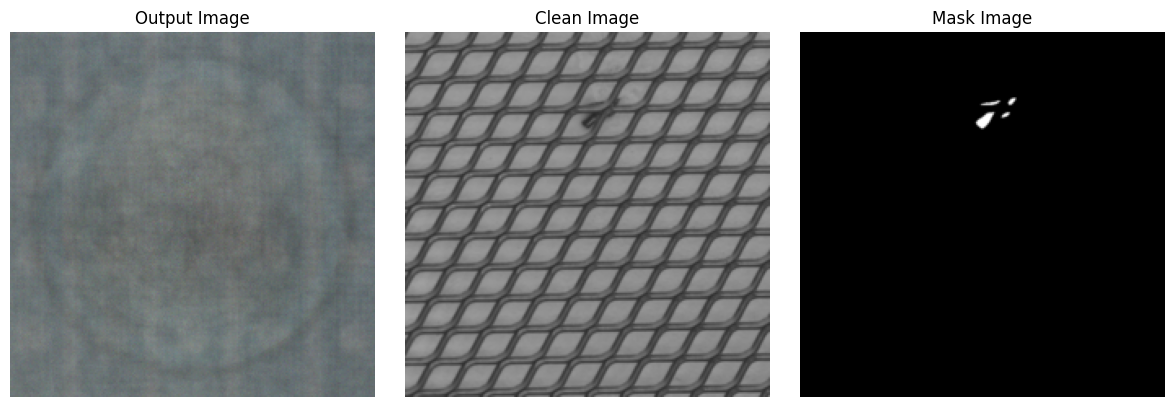

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 17.2723135504886, SSIM: 0.525118887424469
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 18.574194924476647, SSIM: 0.4678448736667633
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 17.02084629697187, SSIM: 0.563538134098053
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 17.576859805910146, SS

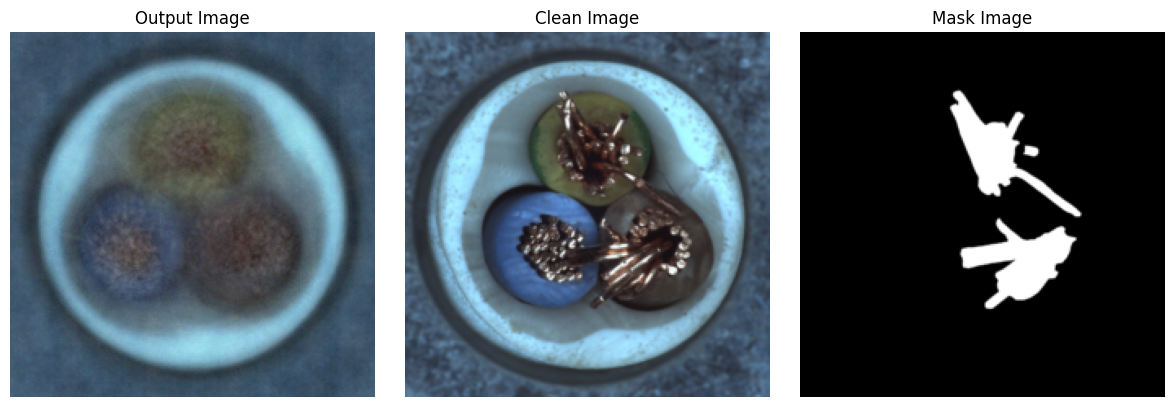

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 18.510915309934216, SSIM: 0.7461610436439514
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 18.875865823523313, SSIM: 0.742852509021759
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 17.321739820082932, SSIM: 0.6652124524116516
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 21.685225606917527

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021548782..0.8633881].


Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 30.12597558204262, SSIM: 0.8470326066017151


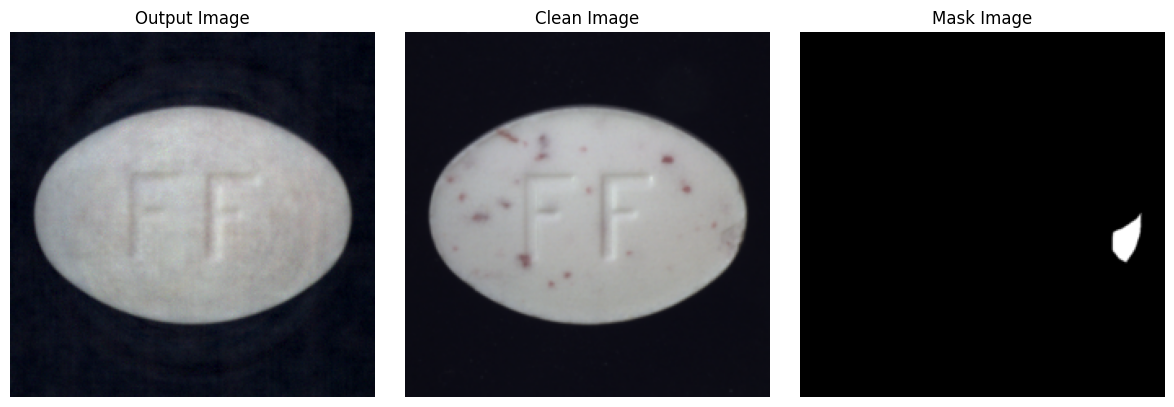

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 28.744476685650525, SSIM: 0.8424354791641235
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.844525755461344, SSIM: 0.8551413416862488
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 29.659349551607875, SSIM: 0.8542786836624146
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.33878461774074

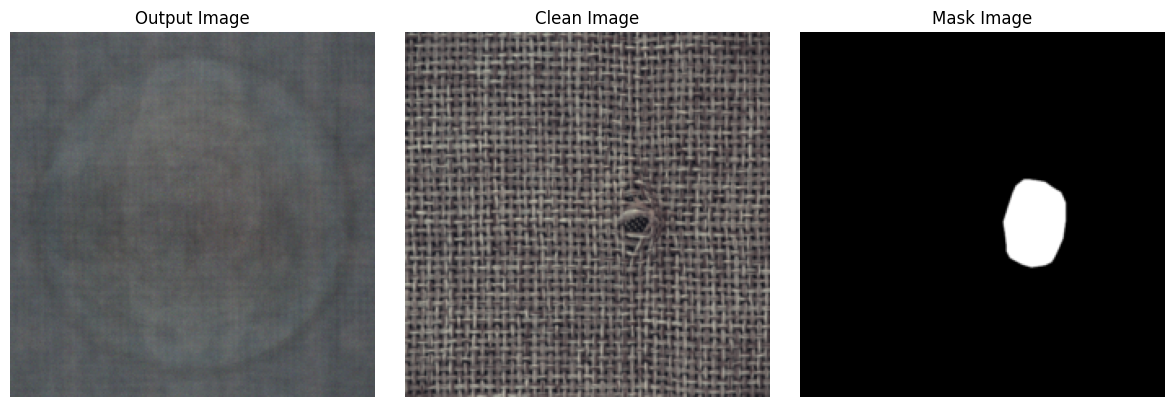

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 18.94799218933891, SSIM: 0.1877901703119278
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 19.37202859635361, SSIM: 0.37726449966430664
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 18.886556181018324, SSIM: 0.2810472548007965
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 19.4491079997187, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003462933..1.0497777].


Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.492156609881185, SSIM: 0.785619854927063


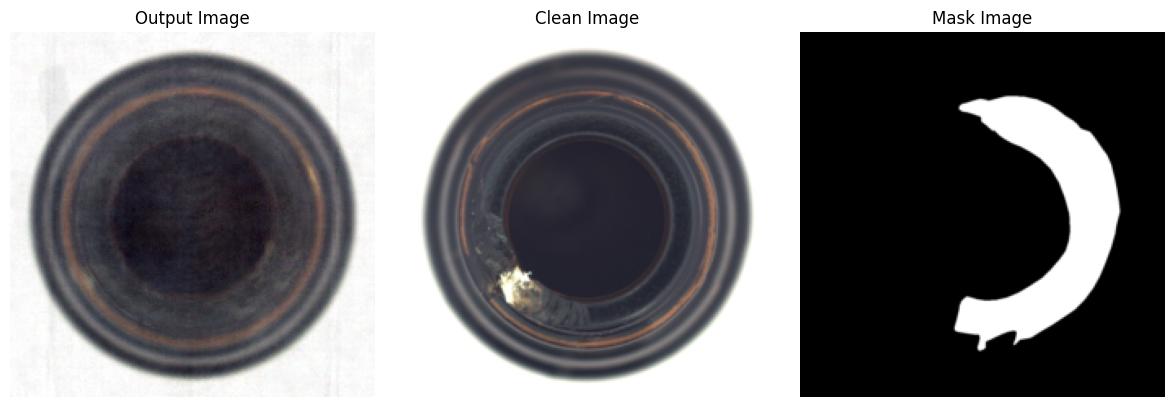

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 21.357244816836168, SSIM: 0.7619962692260742
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 24.488823891251066, SSIM: 0.7650774121284485
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 22.912393963217212, SSIM: 0.7762826085090637
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.13446077648678

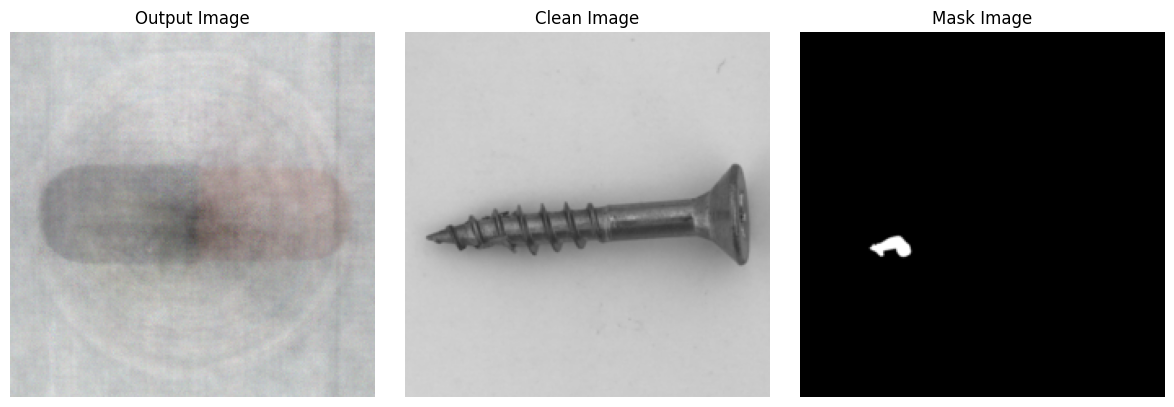

Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 19.669297791218924, SSIM: 0.6528439521789551
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 20.072544288635093, SSIM: 0.7796540856361389
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 27.681280881127968, SSIM: 0.8637086749076843
Clean image shape: (3, 224, 224)
Output image shape: (3, 224, 224)
Mask image shape: (224, 224)
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
PSNR: 23.45756503450603

In [ ]:
import matplotlib.pyplot as plt
# Load test or validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  #Currently given bathc_size = 1

psnr_values = []
ssim_values = []

with torch.no_grad():
    for degraded, clean, mask, label in val_loader:
        degraded = degraded.to(device)
        outputs = model(degraded)

        # Convert tensors to numpy arrays for each image in the batch
        output_images = outputs.cpu().numpy()
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        # Loop through each image in the batch
        for i in range(output_images.shape[0]):
            output_image = output_images[i].squeeze()
            clean_image = clean_images[i].squeeze()
            mask_image = mask_images[i].squeeze()

            # Check image shapes before calculating metrics
            print(f'Clean image shape: {clean_image.shape}')
            print(f'Output image shape: {output_image.shape}')
            print(f'Mask image shape: {mask_image.shape}')


            # Calculate metrics for each image
            psnr, ssim = calculate_metrics(clean_image, output_image)
            print(f'PSNR: {psnr}, SSIM: {ssim}')

            if i ==0: 

                # Transpose if necessary for visualization
                output_img = np.transpose(output_image, (1, 2, 0)) if output_image.ndim == 3 else output_image
                clean_img = np.transpose(clean_image, (1, 2, 0)) if clean_image.ndim == 3 else clean_image
                mask_img = np.transpose(mask_image, (1, 2, 0)) if mask_image.ndim == 3 else mask_image

                # Set up a figure with 1 row and 3 columns
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                # Plot each image in a separate subplot
                axs[0].imshow(output_img)
                axs[0].axis('off')
                axs[0].set_title('Output Image')

                axs[1].imshow(clean_img)
                axs[1].axis('off')
                axs[1].set_title('Clean Image')

                axs[2].imshow(mask_img, cmap='gray')
                axs[2].axis('off')
                axs[2].set_title('Mask Image')

                plt.tight_layout()
                plt.show()

            psnr_values.append(psnr)
            ssim_values.append(ssim)

    # Calculate average PSNR and SSIM
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)

# Print average values
print(f"Average PSNR for the entire test set: {average_psnr:.2f}")
print(f"Average SSIM for the entire test set: {average_ssim:.2f}")


Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.59580823240539, Defect SSIM: 0.9986931681632996


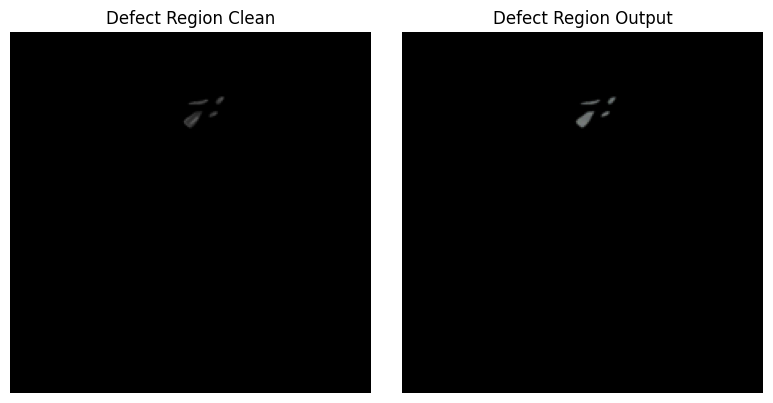

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.03934372549992, Defect SSIM: 0.9892677664756775
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.85037741556594, Defect SSIM: 0.9970482587814331
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 32.19584163602927, Defect SSIM: 0.9897946119308472
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.23328800882712, Defect SSIM: 0.9974632263183594
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.332083639029555, Defect SSIM: 0.9936126470565796
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 29.844

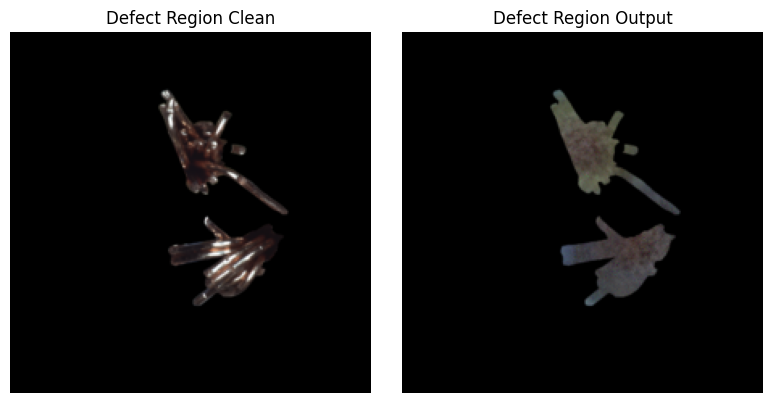

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 33.665470153781854, Defect SSIM: 0.9873729348182678
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 30.03283616923617, Defect SSIM: 0.9690923094749451
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 24.407063905079717, Defect SSIM: 0.932200014591217
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 34.86082170853465, Defect SSIM: 0.9954382181167603
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 31.328773222018185, Defect SSIM: 0.9810462594032288
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 18.51

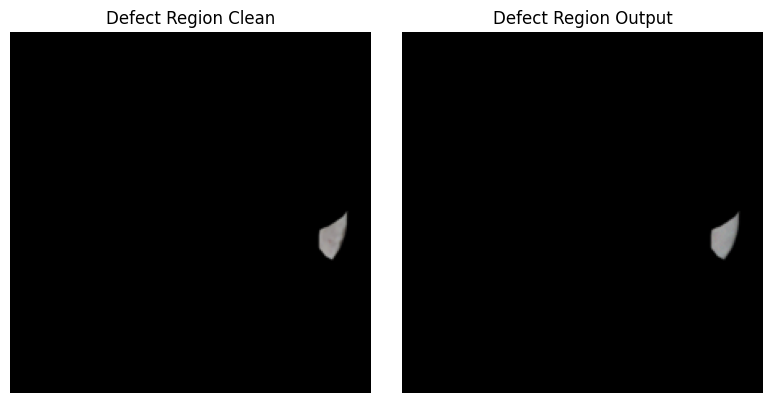

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 41.06491203553132, Defect SSIM: 0.995383083820343
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 40.06068325318807, Defect SSIM: 0.9970151782035828
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 44.0741209079939, Defect SSIM: 0.9947911500930786
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 24.123511485991706, Defect SSIM: 0.7768356204032898
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 33.00459954011026, Defect SSIM: 0.9916883707046509
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 54.43446

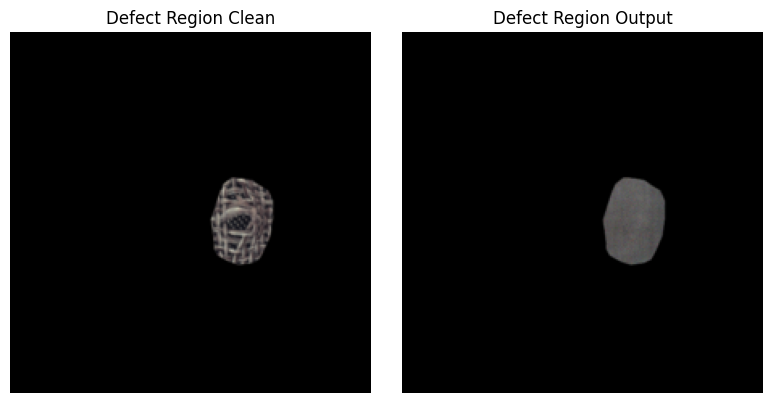

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.704239606716826, Defect SSIM: 0.9944084882736206
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 42.74914387288925, Defect SSIM: 0.9987664818763733
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 39.758344770274675, Defect SSIM: 0.9975163340568542
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 32.64249624845202, Defect SSIM: 0.9669268727302551
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 48.92845580919662, Defect SSIM: 0.9997750520706177
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 43.85

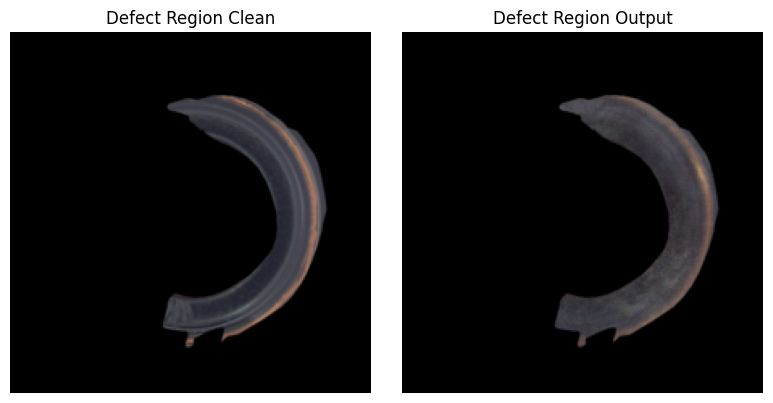

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 23.518026086161996, Defect SSIM: 0.9657838940620422
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.86815138278982, Defect SSIM: 0.9932969808578491
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 27.742526686047437, Defect SSIM: 0.9947410821914673
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 38.559657467043685, Defect SSIM: 0.9976679086685181
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.18637575904477, Defect SSIM: 0.9849961400032043
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.0

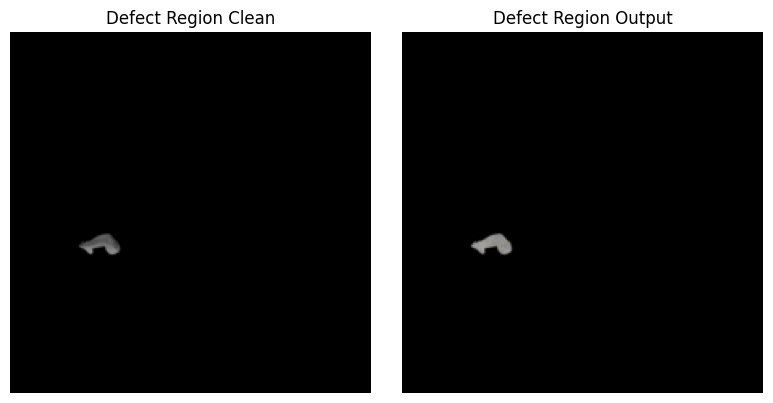

Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 47.74103408497075, Defect SSIM: 0.998698890209198
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 46.99941466699633, Defect SSIM: 0.999049186706543
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 35.431397847640326, Defect SSIM: 0.9909866452217102
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 25.024856083211326, Defect SSIM: 0.9488015174865723
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 31.738375172654628, Defect SSIM: 0.990576446056366
Original shape: (3, 224, 224), Restored shape: (3, 224, 224)
Original dtype: float32, Restored dtype: float32
Defect PSNR: 23.7691

In [ ]:
import matplotlib.pyplot as plt

psnr_values_defect = []
ssim_values_defect = []

with torch.no_grad():
    for degraded, clean, mask, label in val_loader:
        degraded = degraded.to(device)
        outputs = model(degraded)

        # Convert tensors to numpy arrays while keeping the batch dimension
        output_images = outputs.cpu().numpy()  # Shape: (batch_size, C, H, W)
        clean_images = clean.cpu().numpy()
        mask_images = mask.cpu().numpy()

        for i in range(output_images.shape[0]):  # Loop over each image in the batch
            output_image = output_images[i]  # Shape: (C, H, W)
            clean_image = clean_images[i]
            mask_image = mask_images[i]

            # Isolate defect regions using the mask
            defect_region_output = output_image * mask_image
            defect_region_clean = clean_image * mask_image

           # Calculate PSNR and SSIM over defect regions only
            psnr_defect, ssim_defect = calculate_metrics(defect_region_clean, defect_region_output)
            print(f'Defect PSNR: {psnr_defect}, Defect SSIM: {ssim_defect}')

            if i == 0:

                # Transpose for displaying with matplotlib
                defect_region_output = np.transpose(defect_region_output, (1, 2, 0))  # (H, W, C)
                defect_region_clean = np.transpose(defect_region_clean, (1, 2, 0))

                # Display defect regions
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(defect_region_clean)
                axs[0].axis('off')
                axs[0].set_title('Defect Region Clean')

                axs[1].imshow(defect_region_output)
                axs[1].axis('off')
                axs[1].set_title('Defect Region Output')

                plt.tight_layout()
                plt.show()

            # Append to lists
            psnr_values_defect.append(psnr_defect)
            ssim_values_defect.append(ssim_defect)

    # Calculate average defect PSNR and SSIM
    average_psnr_defect = np.mean(psnr_values_defect)
    average_ssim_defect = np.mean(ssim_values_defect)

# Print or save the defect-specific average PSNR and SSIM
print(f"Average PSNR for defect regions: {average_psnr_defect:.2f}")
print(f"Average SSIM for defect regions: {average_ssim_defect:.2f}")
